In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Organize imports

In [81]:
from pathlib import Path
from datetime import datetime

In [31]:
import numpy as np

In [32]:
from collections import OrderedDict

In [43]:
import PIL
from PIL.Image import Image

In [53]:
import matplotlib.pyplot as plt

In [106]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torchvision
from torchvision import (transforms, datasets)
from torchvision import models 

```python
! conda install pytorch torchvision torchaudio -c pytorch
```

```python
! pip install pytorch-lightning
```

In [69]:
from pytorch_lightning import LightningModule, Trainer

In [72]:
from torchmetrics import Accuracy

## Train Letters classificartion with convolutional neural networkm

#### Prepare data

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
tfms = transforms.Compose([transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))])

In [11]:
path = Path('data')
path.mkdir(exist_ok=True)

In [12]:
image_path = path / 'geomnist_dataset'

In [13]:
geoletters = path / 'geoletters'
geoletters.mkdir(exist_ok=True)

In [14]:
# ! cp /content/drive/My\ Drive/datasets/letters/trained_data/geomnist_dataset.zip {path}

In [ ]:
! wget https://github.com/MaxinAI/school-of-ai/raw/master/data/geoletters/geomnist_dataset.zip {geoletters}

In [219]:
import zipfile
with zipfile.ZipFile(path / 'geoletters' / 'geomnist_dataset.zip' , 'r') as zip_ref:
    zip_ref.extractall(path)

## Initialize all additional functions at once

In [220]:
x_test = torch.randn(64 , 3, 7, 7)
x_test.size()

torch.Size([64, 3, 7, 7])

In [221]:
fl = nn.Flatten()
ft = fl(x_test)
ft.size()

torch.Size([64, 147])

In [222]:
def conv_layer(
    ni: int, nf: int, stride: int = 1, kernel: int = 3, 
    padding: int = 1) -> nn.Module:
    return nn.Sequential(
        nn.Conv2d(
            ni, nf, kernel_size=(kernel, kernel), stride=(stride, stride), 
            padding=(padding, padding), bias=False),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(nf)
    )

In [223]:
?? conv_layer

In [224]:
cl = conv_layer(256, 256)
cl

Sequential(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [225]:
def conv2(ni:int, nf:int): 
    return conv_layer(ni, nf, stride=2)

In [226]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
        
    def forward(self, x): 
        return x + self.conv2(self.conv1(x))

Why do we duplicate ```python conv_layer ```?

In [227]:
res_block = ResBlock(256)
res_block

ResBlock(
  (conv1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [228]:
res_block = ResBlock(256)
res_block

ResBlock(
  (conv1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [229]:
??res_block

In [230]:
?? nn.Sequential

In [231]:
def conv_and_res(ni, nf): 
    return nn.Sequential(conv2(ni, nf), res_block(nf))

In [232]:
def img_loader(img_path:Path):
    with open(img_path, mode='rb') as fl:
        with PIL.Image.open(fl) as img:
            return img.convert('L')

## Prepare data loaders

In [233]:
train_dataset = datasets.ImageFolder(image_path / 'train_geo', loader=img_loader, transform=tfms)
valid_dataset = datasets.ImageFolder(image_path / 'val_geo', loader=img_loader, transform=tfms)
test_dataset = datasets.ImageFolder(image_path / 'test_geo', loader=img_loader, transform=tfms)

In [234]:
train_dataset, valid_dataset, train_dataset

(Dataset ImageFolder
     Number of datapoints: 27367
     Root location: data/geomnist_dataset/train_geo
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset ImageFolder
     Number of datapoints: 9096
     Root location: data/geomnist_dataset/val_geo
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset ImageFolder
     Number of datapoints: 27367
     Root location: data/geomnist_dataset/train_geo
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [235]:
?DataLoader

In [236]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [237]:
test_dataset[0][0].shape

torch.Size([1, 32, 32])

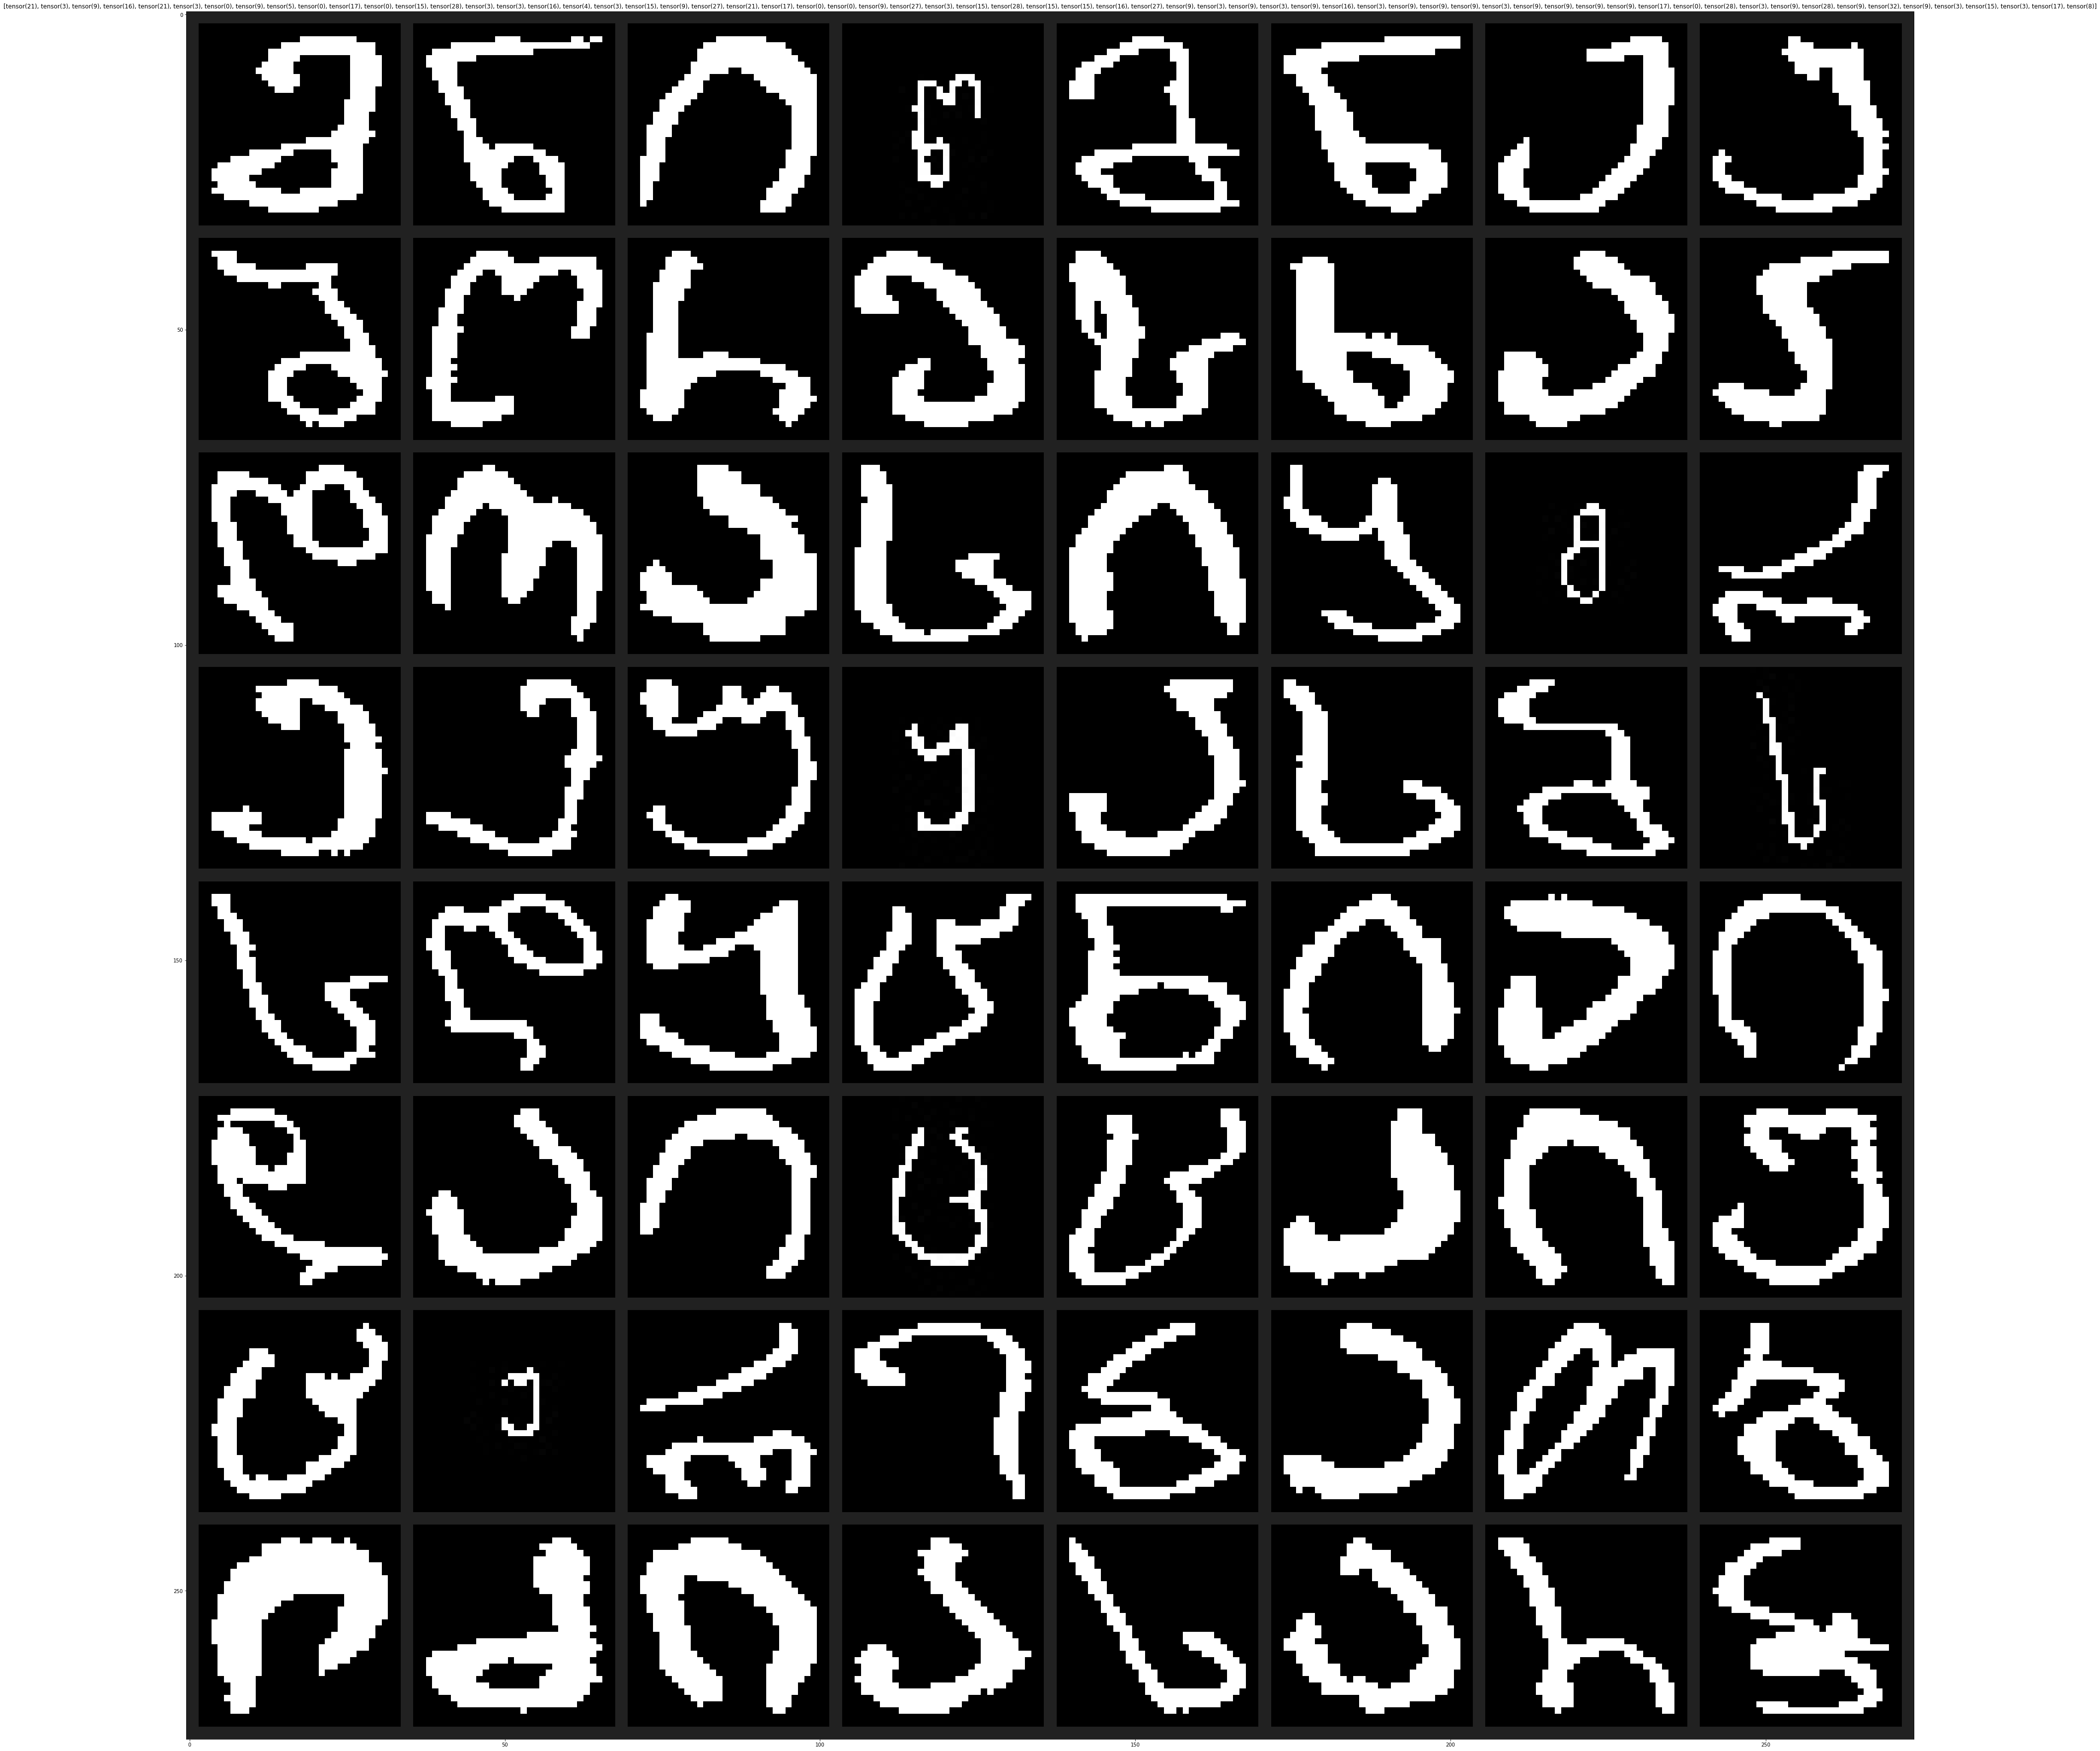

In [238]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.1307])
    std = np.array([0.3081])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(64, 64))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes[x] for x in classes])

In [240]:
loss_func = nn.CrossEntropyLoss()

#### Model initialization

In [61]:
?? nn.Flatten

In [242]:
input_channels = 1

In [243]:
lower_body = nn.Sequential(OrderedDict([('conv1', nn.Conv2d(input_channels, 32, 3)),
#                                         ('bn1', nn.BatchNorm2d(32)),
                                        ('relu1', nn.ReLU(inplace=True)),
                                        ('mxpl1', nn.MaxPool2d(2, 2)),
                                        ('conv2', nn.Conv2d(32, 64, kernel_size=3)),
#                                         ('bn2', nn.BatchNorm2d(64)),
                                        ('relu2', nn.ReLU(inplace=True)),
                                        ('mxpl2', nn.MaxPool2d(2, 2)),
                                        ('drop1', nn.Dropout2d(p=0.25))]))

In [244]:
conv_body = nn.Sequential(OrderedDict([('conv3', nn.Conv2d(64, 128, kernel_size=3)),
#                                        ('bn3', nn.BatchNorm2d(128)),
                                       ('relu3', nn.ReLU(inplace=True)),
                                       ('mxpl3', nn.MaxPool2d(2, 2)),
                                       ('drop2', nn.Dropout2d(p=0.25))]))

In [245]:
linear_body = nn.Sequential(OrderedDict([('flatten', nn.Flatten()),
                                         ('ln1', nn.Linear(2 * 2 * 128, 1024, bias=True)),
#                                          ('bn2', nn.BatchNorm1d(1024)),
                                         ('relu3', nn.ReLU(inplace=True)),
                                         ('drop2', nn.Dropout(p=0.25))]))

In [246]:
class LetterNet(nn.Module):
    """Full double letters network implementation"""

    def __init__(self, input_channels=1, num_classes=33):
        super(LetterNet, self).__init__()
        self.conv_part = lower_body
        self.dub_part = conv_body
        self.fc_part = linear_body
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.conv_part(x)
        x = self.dub_part(x)
        x = self.fc_part(x)
        logits = self.fc(x)

        return logits



In [247]:
def conv_out(w:int, k: int, p: int, s: int):
    return int(((w - k + 2*p)/s)+1)

In [248]:
conv_out(32, 3, 0, 1)

30

In [249]:
conv_out(conv_out(conv_out(conv_out(32, 3, 0, 1), 2, 0, 1), 3, 0, 1), 2, 0, 1)

26

In [250]:
class LetterNet2(nn.Module):
    """Full double letters network implementation"""

    def __init__(self, input_channels=1, num_classes=33):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(6 * 6 * 64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
#         logits = self.pool2(x)
        x = self.pool2(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc(x)

        return logits

In [251]:
sz = 32 # 34
x_test = torch.randn(4 , 1, sz, sz)

In [252]:
model = LetterNet2()

In [253]:
o_test = model(x_test)
o_test.shape

torch.Size([4, 33])

In [146]:
model = LetterNet()

In [254]:
model

LetterNet2(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2304, out_features=33, bias=True)
)

## Create lightning module

In [255]:
class LennerNetLt(LightningModule):
    def __init__(
        self, model: nn.Module, loss_fn=F.nll_loss, metrics=Accuracy()):
        super().__init__()
        self.model = model
        self.accuracy = metrics
        self.lr=0.01

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        logits = self(x)
        log_s = F.log_softmax(logits, dim=1)
        loss = F.nll_loss(log_s, y)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        log_s = F.log_softmax(logits, dim=1)
        loss = F.nll_loss(log_s, y)
        preds = torch.argmax(log_s, dim=1)
        self.accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.accuracy, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        
        return optimizer


In [256]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
AVAIL_GPUS

0

In [257]:
model_lt = LennerNetLt(model)
trainer = Trainer(
    gpus=AVAIL_GPUS,
    max_epochs=3,
    progress_bar_refresh_rate=20,
    auto_lr_find=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [258]:
! ls {geoletters}

geoletters_09_06_2022      geomnist_dataset.zip
geoletters_labels.json     mnist_weights.pth.tar
geoletters_weights.pth.tar


In [259]:
curr_date = datetime.now().strftime('%d_%m_%Y').lower()
curr_date

'09_06_2022'

In [260]:
geletters_ckpts = geoletters / f'geoletters_{curr_date}'
geletters_ckpts.mkdir(exist_ok=True)

## Train model

In [145]:
trainer.fit(
    model_lt, train_loader, valid_loader)


  | Name     | Type      | Params
---------------------------------------
0 | model    | LetterNet | 651 K 
1 | accuracy | Accuracy  | 0     
---------------------------------------
651 K     Trainable params
0         Non-trainable params
651 K     Total params
2.607     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/levan/anaconda3/envs/edu2/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/levan/anaconda3/envs/edu2/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import

Training: 0it [00:00, ?it/s]

/Users/levan/anaconda3/envs/edu2/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


#### Find learning rate

In [261]:
lr_finder = trainer.tuner.lr_find(
    model_lt, train_loader, valid_loader)

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /Users/levan/git/school-of-ai/.lr_find_a37c89c8-2465-46d4-921a-fcf63e9ce93b.ckpt


In [262]:
# Results can be found in
lr_finder.results

{'lr': [1e-08,
  1.4454397707459274e-08,
  1.7378008287493753e-08,
  2.0892961308540398e-08,
  2.51188643150958e-08,
  3.019951720402016e-08,
  3.630780547701014e-08,
  4.36515832240166e-08,
  5.248074602497726e-08,
  6.309573444801934e-08,
  7.585775750291837e-08,
  9.120108393559096e-08,
  1.0964781961431852e-07,
  1.3182567385564074e-07,
  1.5848931924611133e-07,
  1.9054607179632475e-07,
  2.2908676527677735e-07,
  2.7542287033381663e-07,
  3.311311214825911e-07,
  3.9810717055349735e-07,
  4.786300923226383e-07,
  5.75439937337157e-07,
  6.918309709189366e-07,
  8.317637711026709e-07,
  1e-06,
  1.2022644346174132e-06,
  1.445439770745928e-06,
  1.7378008287493761e-06,
  2.089296130854039e-06,
  2.5118864315095797e-06,
  3.0199517204020163e-06,
  3.630780547701014e-06,
  4.365158322401661e-06,
  5.248074602497728e-06,
  6.3095734448019305e-06,
  7.585775750291836e-06,
  9.120108393559096e-06,
  1.0964781961431852e-05,
  1.3182567385564076e-05,
  1.584893192461114e-05,
  1.90546071

/var/folders/t0/pbj59l394sdcgxqh8gvj099h0000gn/T/ipykernel_37469/2640854576.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


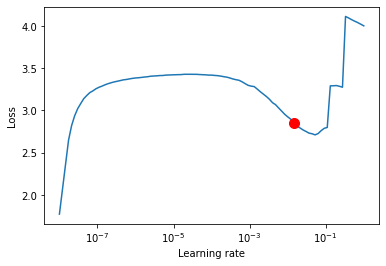

In [263]:
# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [264]:
# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model_lt.lr = new_lr
new_lr

0.01445439770745928

In [265]:
trainer.tune(
    model, train_loader, valid_loader)

{}

In [266]:
trainer.fit(
    model_lt, train_loader, valid_loader)


  | Name     | Type       | Params
----------------------------------------
0 | model    | LetterNet2 | 94.9 K
1 | accuracy | Accuracy   | 0     
----------------------------------------
94.9 K    Trainable params
0         Non-trainable params
94.9 K    Total params
0.380     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

RuntimeError: value cannot be converted to type float without overflow

#### Size dependency

In [116]:
model

LennerNetLt(
  (model): LennerNetLt(
    (model): LennerNetLt(
      (model): LennerNetLt(
        (model): LetterNet(
          (conv_part): Sequential(
            (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (mxpl1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (mxpl2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            (drop1): Dropout2d(p=0.25, inplace=False)
          )
          (dub_part): Sequential(
            (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
            (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

In [119]:
sz = 32 # 34
x_test = torch.randn(4 , 1, sz, sz)

In [217]:
model(x_test)

tensor([[ 1.7998e+38,  1.7504e+38, -1.7414e+38,  1.5099e+38,  8.4597e+37,
         -5.9743e+37, -3.0798e+38,  1.2286e+38,  1.4771e+38,  1.3913e+37,
          1.0486e+38,  1.1501e+38, -2.5577e+38,  9.9538e+37,  1.1389e+38,
          7.3315e+37,        -inf, -1.3837e+38,  1.4638e+38,  1.8264e+38,
         -1.8817e+38,        -inf,  6.5520e+37,  8.9752e+37,  1.6383e+38,
         -1.3527e+38,  4.1359e+36, -1.4530e+38,  1.1103e+38,  6.7979e+37,
          9.3139e+36, -4.3742e+17, -4.5913e+17],
        [ 1.7998e+38,  1.7504e+38, -1.7414e+38,  1.5099e+38,  8.4597e+37,
         -5.9743e+37, -3.0798e+38,  1.2286e+38,  1.4771e+38,  1.3913e+37,
          1.0486e+38,  1.1501e+38, -2.5577e+38,  9.9538e+37,  1.1389e+38,
          7.3315e+37,        -inf, -1.3837e+38,  1.4638e+38,  1.8264e+38,
         -1.8817e+38,        -inf,  6.5520e+37,  8.9752e+37,  1.6383e+38,
         -1.3527e+38,  4.1359e+36, -1.4530e+38,  1.1103e+38,  6.7979e+37,
          9.3139e+36, -4.3742e+17, -4.5913e+17],
        [ 1.79

## FastAI for MNIST classifier

In [218]:
?? conv_layer

In [122]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 33), # 1
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()      # remove (1,1) grid
)

In [123]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Sequential(
    (0): Conv2d(16, 33, kernel_size=(3, 3), stride=(2, 2), paddin

#### Adaptive (global) pooling

In [124]:
sz = 32 # 34
x_test = torch.randn(4 , 1, sz, sz)
x_test.size()

torch.Size([4, 1, 32, 32])

In [125]:
y = model(x_test)
y.size()

torch.Size([4, 33])

In [126]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

NameError: name 'Learner' is not defined

In [73]:
print(learn.summary)

<bound method model_summary of Learner(data=DataBunch;

Train: Dataset ImageFolder
    Number of datapoints: 27367
    Root location: data/geomnist_dataset/train_geo
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           );

Valid: Dataset ImageFolder
    Number of datapoints: 9096
    Root location: data/geomnist_dataset/val_geo
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           );

Test: Dataset ImageFolder
    Number of datapoints: 9096
    Root location: data/geomnist_dataset/test_geo
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           ), model=Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affin

In [74]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.941702,0.853926,0.762093,00:30
1,0.739647,0.733043,0.793096,00:25
2,0.654523,0.643120,0.821570,00:22
3,0.578901,0.667459,0.810026,00:22
4,0.502673,0.506725,0.854991,00:22
5,0.434942,0.466903,0.866425,00:27
6,0.373366,0.359962,0.901935,00:20
7,0.275294,0.321161,0.916447,00:23
8,0.228469,0.296617,0.923483,00:24
9,0.180277,0.297980,0.924033,00:18


In [ ]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 33),
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer()
)

In [ ]:
model

In [ ]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, max_lr=0.05)

In [83]:
#learn.load('res_stage_1')
state_dict = torch.load(str(path / 'models' / 'res_stage_1.pth'), map_location='cpu')

In [88]:
weights_dict = state_dict['model']

## Bigger model with residual connections

In [97]:
??conv_and_res

In [96]:
conv_and_res(1, 32)

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not int

In [89]:
model = nn.Sequential(
    conv_and_res(1, 32),
    conv_and_res(32, 64),
    conv_and_res(64, 128),
    conv_and_res(128, 256),
    conv_and_res(256, 512),
    conv2(512, 33),
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer()
)

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not int

In [ ]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 2e-2)

In [ ]:
learn.fit_one_cycle(8, 2e-2)

#### Add regularization

In [ ]:
model = nn.Sequential(
    conv_and_res(1, 32),
    conv_and_res(32, 64),
    conv_and_res(64, 128),
    conv_and_res(128, 256),
    conv_and_res(256, 512),
    conv2(512, 1024),
    nn.AdaptiveAvgPool2d((1, 1)),
    FlattenLayer(),
    nn.Linear(1024, 512),
    nn.Dropout(p=0.25),
    nn.Linear(512, 512),
    nn.Dropout(p=0.5),
    nn.Linear(512, 33))

In [ ]:
model

In [ ]:
from utils.logging.time_logger import start_timer

In [ ]:
sz = 32 # 34
x_test = torch.randn(4 , 1, sz, sz)

In [ ]:
tm = start_timer(True, model)
y = model(x_test)
tm.timeit()

In [ ]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(28, 2e-2)

## Serialize model

In [ ]:
model_path = path / 'models'
model_path.mkdir(exist_ok=True)

In [ ]:
model = learn.model

In [ ]:
torch.save(model.state_dict(), str(model_path / 'mnist_resnet.pth'))

In [ ]:
state_dict = torch.load(str(path / 'models' / 'mnist_resnet.pth'), map_location='cpu')

In [ ]:
state_dict

## Image search

In [98]:
import cv2

In [99]:
from torch import no_grad
from torch.jit import ScriptModule
from torchvision.models import (resnet34, resnet50, wide_resnet50_2)

In [100]:
size = 256
imsz = 224
IMG_SUFF = {'.jpg', '.jpeg', '.png'}

In [101]:
class ToPILImage(object):
    """Convert inout image to PIL image"""

    def __init__(self, mode=None):
        super().__init__()
        self.to_pil = transforms.ToPILImage(mode=mode)

    def convert(self, img: Union[np.ndarray, Image]):
        """
        Converts image to the PIL format
        Args:
            img: inout image

        Returns:
            converted image
        """
        return img if isinstance(img, Image) else self.to_pil(img)

    def __call__(self, *args, **kwargs):
        return self.convert(*args, **kwargs)

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        if self.to_pil.mode is not None:
            format_string += f'mode={self.to_pil.mode}'
        format_string += ')'
        return format_string


class Img2Vec(object):
    """Model wrapper for image embedding"""

    def __init__(self, backbone: Union[nn.Module, ScriptModule], trfm: transforms, device: str = 'cpu'):
        super().__init__()
        self.device = torch.device(device)
        self.backbone = (backbone.eval() if hasattr(backbone, 'eval') else backbone).to(device)
        self.trfm = trfm

    def preprocess(self, *xs: np.ndarray) -> Tensor:
        """
        Transform data before model
        Args:
            *xs: input data

        Returns:
            processed data for model
        """
        return torch.stack([self.trfm(x) for x in xs]).to(self.device)

    @no_grad()
    def forward(self, *xs: np.ndarray) -> np.ndarray:
        tns = self.preprocess(*xs)
        rts = self.backbone(tns)
        y = rts.cpu().data.numpy()

        return y

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [102]:
vec_trsfm = transforms.Compose([ToPILImage(mode='RGB'),
                                transforms.Resize(size),
                                transforms.CenterCrop(imsz),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#### Prepare data

In [103]:
search_path = path / 'search'

In [117]:
dir_paths = [dp for dp in search_path.iterdir() if dp.is_dir()]

In [118]:
dir_paths

[PosixPath('data/search/places'),
 PosixPath('data/search/fortresses'),
 PosixPath('data/search/streets'),
 PosixPath('data/search/charches_small'),
 PosixPath('data/search/churches'),
 PosixPath('data/search/rivers')]

In [119]:
img_pts = [im_pt for dp in dir_paths for im_pt in dp.iterdir() if im_pt.suffix in IMG_SUFF]

In [120]:
def read_img(im_pt):
    img = cv2.imread(str(im_pt), cv2.IMREAD_ANYCOLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    return img

In [121]:
imgs = [read_img(ip) for ip in img_pts]

#### Initialize features extractor

In [122]:
cut = 1

In [202]:
body = wide_resnet50_2(pretrained=True)

In [203]:
body

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [204]:
backbone = nn.Sequential(*list(body.children())[:-cut])
net = nn.Sequential(backbone, FlattenLayer())

In [205]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [206]:
img_vec = Img2Vec(net, vec_trsfm, device='cpu')

In [207]:
vecs = [img_vec(im)[0] for im in imgs]

In [208]:
vecs[0].shape, len(vecs)

((512,), 156)

In [209]:
img_vecs = list(zip(imgs, vecs))

In [210]:
img_vecs

[(array([[[167, 194, 223],
          [167, 194, 223],
          [169, 196, 225],
          [170, 197, 226],
          ...,
          [151, 180, 214],
          [151, 180, 212],
          [150, 179, 211],
          [149, 178, 210]],
  
         [[167, 194, 223],
          [168, 195, 224],
          [169, 196, 225],
          [171, 198, 227],
          ...,
          [151, 180, 214],
          [151, 180, 212],
          [150, 179, 211],
          [150, 179, 211]],
  
         [[168, 195, 224],
          [169, 196, 225],
          [170, 197, 226],
          [172, 199, 228],
          ...,
          [152, 181, 215],
          [152, 181, 213],
          [151, 180, 212],
          [150, 179, 211]],
  
         [[170, 197, 226],
          [170, 197, 226],
          [172, 199, 228],
          [173, 200, 229],
          ...,
          [153, 182, 216],
          [153, 182, 214],
          [152, 181, 213],
          [151, 180, 212]],
  
         ...,
  
         [[ 96, 105, 114],
          [ 98, 

#### Compare vectors

In [6]:
from scipy.spatial.distance import cosine

In [7]:
import matplotlib.pyplot as plt

In [8]:
def top_vecs(qi, top_k=5):
    qv = img_vec(qi)[0]
    resul_pts = [(cosine(qv, vc), pt) for pt, vc in img_vecs]
    resul_pts = sorted(resul_pts, key=lambda x: x[0], reverse=False)
    resul_pts = resul_pts[:top_k]
    
    return resul_pts

#### Query images

In [9]:
query_path = path / 'queries'
query_path.mkdir(exist_ok=True)

NameError: name 'path' is not defined

In [215]:
qim = read_img(query_path / 'ct_2.jpg')

In [216]:
res = top_vecs(qim)

In [217]:
#res

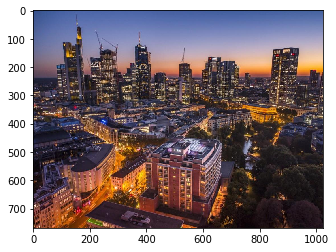

In [218]:
plt.imshow(qim)
plt.show()
plt.close()

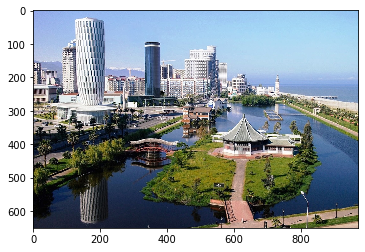

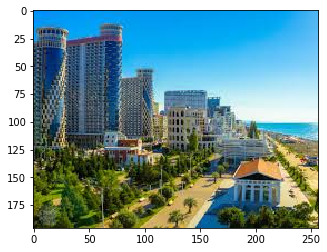

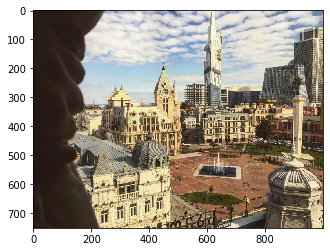

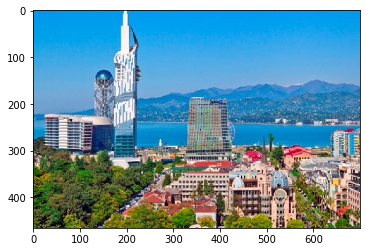

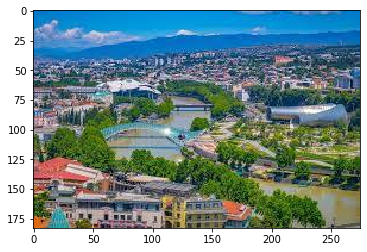

In [219]:
for dist, res_img in res:
    plt.imshow(res_img)
    plt.show()
    plt.close()

## Fine tuning FastAI

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
bs = 64

In [ ]:
path = untar_data(URLs.PETS); path

In [ ]:
path.ls()

In [ ]:
fnames = get_image_files(path_img)
fnames[:5]

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), 
                                   size=224, bs=bs).normalize(imagenet_stats)

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
print(data.classes)
len(data.classes),data.c

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.model

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('stage-1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
doc(interp.plot_top_losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

#### Unfreeze and fine-tune

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn.load('stage-1');

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

#### Train bigger model

In [ ]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=tfms,
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('stage-1-50')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

#### Data augmentation

In [ ]:
doc(get_transforms)

In [ ]:
path = path / 'images'

In [ ]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [ ]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [ ]:
data = get_data(224, bs, 'zeros')

In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [ ]:
data = get_data(224,bs)

In [ ]:
plot_multi(_plot, 3, 3, figsize=(8,8))

#### Train with augmentation

In [ ]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [ ]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

In [ ]:
data = get_data(352,bs)
learn.data = data

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

In [ ]:
learn.save('352')

In [ ]:
print(learn.summary())